### raw data stastis

In [3]:
import os
import librosa
from glob import glob
import pandas as pd
from pandarallel import pandarallel
import soundfile as sf
pandarallel.initialize(progress_bar=True, use_memory_fs=False, nb_workers=4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
path = "datas/raws/Đừng_nói_khi_yêu/*.wav"
files = glob(path)
data = pd.DataFrame(files, columns=["path"])
data.head()

,path
0,datas/raws/Đừng_nói_khi_yêu/Đừng nói khi yêu t...
1,datas/raws/Đừng_nói_khi_yêu/Đừng nói khi yêu t...
2,datas/raws/Đừng_nói_khi_yêu/Đừng nói khi yêu t...
3,datas/raws/Đừng_nói_khi_yêu/Preview Đừng nói k...
4,datas/raws/Đừng_nói_khi_yêu/Đừng nói khi yêu t...


In [5]:
def get_duration(path):
    wav, sr = librosa.load(path, sr=16000)

    return wav.shape[0]/sr

In [6]:
new_name = []
for index in data.index:
    path = f"/home/tuyendv/Desktop/codes/ess_data_crawler_pipline/datas/raws/đừng_nói_khi_yêu/wav_{index}.wav"
    new_name.append(path)

In [7]:
new_name_df = pd.DataFrame(new_name, columns=["new_name"])
new_name_df.head()

,new_name
0,/home/tuyendv/Desktop/codes/ess_data_crawler_p...
1,/home/tuyendv/Desktop/codes/ess_data_crawler_p...
2,/home/tuyendv/Desktop/codes/ess_data_crawler_p...
3,/home/tuyendv/Desktop/codes/ess_data_crawler_p...
4,/home/tuyendv/Desktop/codes/ess_data_crawler_p...


In [8]:
temp = pd.concat([data, new_name_df], axis=1)

In [9]:
for index in temp.index:
    wav, sr = librosa.load(temp["path"][index], sr=22050)

    sf.write(temp["new_name"][index], wav, samplerate=22050)

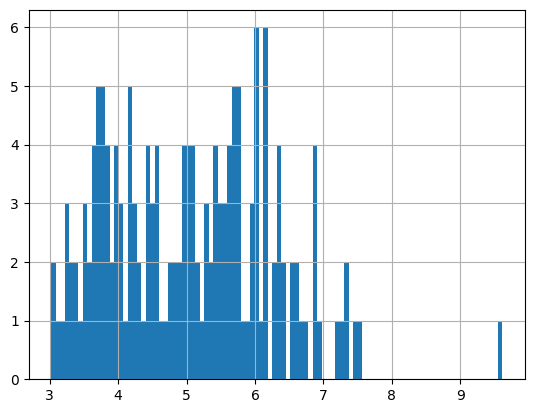

In [9]:
(data["duration"]/60).hist(bins=100)

### youtube data stastis

In [1]:
import os
from glob import glob
import pandas as pd
import librosa

In [2]:
path = "/home/tuyendv/Desktop/small_data"
speaker_dirs = os.listdir(path)
speaker_dirs

['Anime Rewind', 'A Pure Day']

In [3]:
wavs = []
for spk_dir in speaker_dirs:
    spk_dir = f'{path}/{spk_dir}/*/*.wav'
    wav_paths = glob(spk_dir)
    
    wavs+=wav_paths

In [4]:
def duration(path):
    wav, sr = librosa.load(path, sr=16000)

    return wav.shape[0] / sr

In [5]:
wav_df = pd.DataFrame(wavs, columns=["wav"])
wav_df.head()

,wav
0,/home/tuyendv/Desktop/small_data/Anime Rewind/...
1,/home/tuyendv/Desktop/small_data/Anime Rewind/...
2,/home/tuyendv/Desktop/small_data/Anime Rewind/...
3,/home/tuyendv/Desktop/small_data/Anime Rewind/...
4,/home/tuyendv/Desktop/small_data/Anime Rewind/...


In [6]:
wav_df["length"] = wav_df.wav.apply(lambda x: duration(x))

In [7]:
wav_df.head()

,wav,length
0,/home/tuyendv/Desktop/small_data/Anime Rewind/...,3.192
1,/home/tuyendv/Desktop/small_data/Anime Rewind/...,4.536
2,/home/tuyendv/Desktop/small_data/Anime Rewind/...,3.416
3,/home/tuyendv/Desktop/small_data/Anime Rewind/...,3.068
4,/home/tuyendv/Desktop/small_data/Anime Rewind/...,4.056


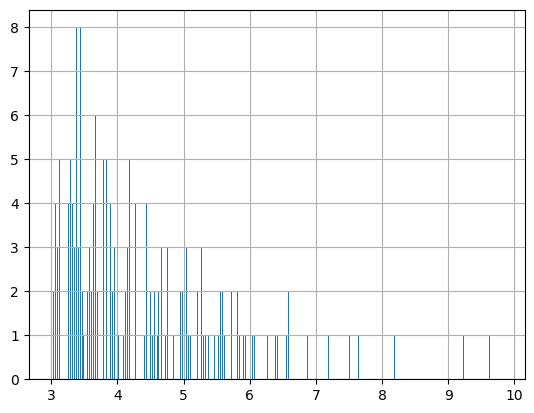

In [8]:
wav_df.length.hist(bins=1000)

### map real speaker to speaker id

In [3]:
from sklearn.model_selection import train_test_split

In [7]:
train_test_split([1, 2, 3, 4], test_size=0.1, random_state=42)

[[4, 1, 3], [2]]

In [2]:
import os
import json

path = "datas"
speakers = os.listdir(path)
speakers

['raws', 'noises', 'diar_datas', 'simulated_datas']

In [10]:
spk2id = {spk: f"speaker_{id}" for id, spk in enumerate(speakers)}

In [11]:
with open("spk2id.json", "w", encoding="utf-8") as f:
    json_obj = json.dumps(spk2id, indent=4, ensure_ascii=False)
    f.write(json_obj)

In [5]:
import librosa
import soundfile as sf
import os
from tqdm import tqdm

In [11]:
in_path = "diar_datas"
out_path = "youtube_datas"

for _dir in tqdm(os.listdir(in_path)):
    abs_dir = os.path.join(in_path, _dir)

    if not os.path.exists(os.path.join(out_path, _dir)):
        os.mkdir(os.path.join(out_path, _dir))
    
    for file in os.listdir(abs_dir):
        abs_path = os.path.join(abs_dir, file)

        wav, sr = librosa.load(abs_path, sr=16000)

        abs_out_path = os.path.join(out_path, _dir, file)
        sf.write(abs_out_path, wav, samplerate=sr)


100%|██████████| 651/651 [08:06<00:00,  1.34it/s]


In [16]:
import pandas as pd
import os
import librosa
from tqdm import tqdm

In [19]:
path = "youtube_datas"
datas = []
for _dir in tqdm(os.listdir(path)):
    abs_dir = path + "/" + _dir
    for file in os.listdir(abs_dir):
        abs_path = os.path.join(abs_dir, file)
        wav, sr = librosa.load(abs_path, sr=16000)
        duration = wav.shape[0] / sr

        datas.append([abs_path, _dir, duration])

100%|██████████| 651/651 [00:22<00:00, 29.26it/s]


In [20]:
datas_df = pd.DataFrame(datas, columns=["path", "spk", "duration"])

In [26]:
temps = []
for name, group in datas_df.groupby("spk"):
    temps.append([name, group["duration"].sum()])

In [27]:
temps = pd.DataFrame(temps, columns=["spk", "duration"])
temps.head()

,spk,duration
0,spk_0,107.972
1,spk_1,81.614
2,spk_10,123.496
3,spk_100,200.720
4,spk_101,143.204


In [34]:
temps["duration"].sum()

128864.156375

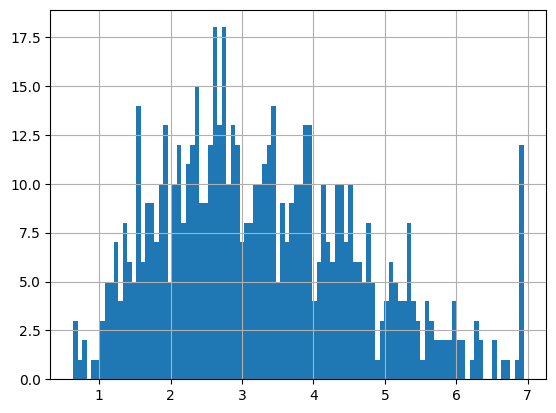

In [31]:
(temps["duration"]/60).hist(bins=100)